# Automated Machine Learning
_**Energy Demand Forecasting**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)

## Introduction
In this example, we show how AutoML can be used to forecast a single time-series in the energy demand application area. 

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

Notebook synopsis:
1. Creating an Experiment in an existing Workspace
2. Configuration and local run of AutoML for a simple time-series model
3. View engineered features and prediction results
4. Configuration and local run of AutoML for a time-series model with lag and rolling window features
5. Estimate feature importance

In [1]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 18:50:55) [MSC v.1915 64 bit (AMD64)]'

In [2]:
import datetime
print("Current date and time: " , datetime.datetime.now())

Current date and time:  2019-08-27 12:40:58.334896


## Setup


In [3]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

As part of the setup you have already created a <b>Workspace</b>. To run AutoML, you also need to create an <b>Experiment</b>. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [4]:
#Install librairies
#!pip install azureml-sdk
#!pip install --upgrade azureml-sdk
#!pip install --upgrade azureml-sdk[automl,notebooks,explain]

In [5]:
#Version
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.0.53


In [6]:
#Workspace
import os
subscription_id = os.environ.get("SUBSCRIPTION_ID", "A COMPLETER")
resource_group = os.environ.get("RESOURCE_GROUP", "azuremlserviceresourcegroup")
workspace_name = os.environ.get("WORKSPACE_NAME", "azuremlservice")


from azureml.core import Workspace
try:
   ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
   ws.write_config()
   print("OK")
except:
   print("Error: Workspace not found")

OK


In [28]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'automl-energydemandforecasting'
# project folder
project_folder = './sample_projects/automl-local-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.53
Workspace,azuremlservice
Resource Group,azuremlserviceresourcegroup
Location,westeurope
Project Directory,./sample_projects/automl-local-energydemandforecasting
Run History Name,automl-energydemandforecasting


## Data
We will use energy consumption data from New York City for model training. The data is stored in a tabular format and includes energy demand and basic weather data at an hourly frequency. Pandas CSV reader is used to read the file into memory. Special attention is given to the "timeStamp" column in the data since it contains text which should be parsed as datetime-type objects. 

In [8]:
data = pd.read_csv('nyc_energy.csv', parse_dates=['timeStamp'])
data.head(20)

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61
5,2012-01-01 05:00:00,4274.70,0.00,39.02
6,2012-01-01 06:00:00,4324.90,0.00,38.78
7,2012-01-01 07:00:00,4350.00,0.00,42.74
8,2012-01-01 08:00:00,4480.90,0.00,38.90
9,2012-01-01 09:00:00,4664.20,0.00,44.67


We must now define the schema of this dataset. Every time-series must have a time column and a target. The target quantity is what will be eventually forecasted by a trained model. In this case, the target is the "demand" column. The other columns, "temp" and "precip," are implicitly designated as features.

In [9]:
# Dataset schema
time_column_name = 'timeStamp'
target_column_name = 'demand'

### Forecast Horizon

In addition to the data schema, we must also specify the forecast horizon. A forecast horizon is a time span into the future (or just beyond the latest date in the training data) where forecasts of the target quantity are needed. Choosing a forecast horizon is application specific, but a rule-of-thumb is that **the horizon should be the time-frame where you need actionable decisions based on the forecast.** The horizon usually has a strong relationship with the frequency of the time-series data, that is, the sampling interval of the target quantity and the features. For instance, the NYC energy demand data has an hourly frequency. A decision that requires a demand forecast to the hour is unlikely to be made weeks or months in advance, particularly if we expect weather to be a strong determinant of demand. We may have fairly accurate meteorological forecasts of the hourly temperature and precipitation on a the time-scale of a day or two, however.

Given the above discussion, we generally recommend that users set forecast horizons to less than 100 time periods (i.e. less than 100 hours in the NYC energy example). Furthermore, **AutoML's memory use and computation time increase in proportion to the length of the horizon**, so the user should consider carefully how they set this value. If a long horizon forecast really is necessary, it may be good practice to aggregate the series to a coarser time scale.  


Forecast horizons in AutoML are given as integer multiples of the time-series frequency. In this example, we set the horizon to 48 hours.

In [10]:
max_horizon = 48

### Split the data into train and test sets
We now split the data into a train and a test set so that we may evaluate model performance. We note that the tail of the dataset contains a large number of NA values in the target column, so we designate the test set as the 48 hour window ending on the latest date of known energy demand. 

In [11]:
# Find time point to split on
latest_known_time = data[~pd.isnull(data[target_column_name])][time_column_name].max()
split_time = latest_known_time - pd.Timedelta(hours=max_horizon)

# Split into train/test sets
X_train = data[data[time_column_name] <= split_time]
X_test = data[(data[time_column_name] > split_time) & (data[time_column_name] <= latest_known_time)]

# Move the target values into their own arrays 
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

## Train

We now instantiate an AutoMLConfig object. This config defines the settings and data used to run the experiment. For forecasting tasks, we must provide extra configuration related to the time-series data schema and forecasting context. Here, only the name of the time column and the maximum forecast horizon are needed. Other settings are described below:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Number of iterations. In each iteration, Auto ML trains a specific pipeline on the given data|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|Number of cross validation splits. Rolling Origin Validation is used to split time-series in a temporally consistent way.|
|**path**|Relative path to the project folder.  AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder. 

In [12]:
time_series_settings = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon
}

automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             blacklist_models = ['ExtremeRandomTrees'],
                             iterations=10,
                             iteration_timeout_minutes=5,
                             X=X_train,
                             y=y_train,
                             n_cross_validations=3,
                             path=project_folder,
                             verbosity = logging.INFO,
                             **time_series_settings)

Submitting the configuration will start a new run in this experiment. For local runs, the execution is synchronous. Depending on the data and number of iterations, this can run for a while. Parameters controlling concurrency may speed up the process, depending on your hardware.

You will see the currently running iterations printing to the console.

In [13]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_fbd7c31f-6e8b-4556-9e42-018f4cc8bf31
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper ElasticNet               0:00:16       0.1324  

In [14]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_fbd7c31f-6e8b-4556-9e42-018f4cc8bf31,automl,Completed,Link to Azure Portal,Link to Documentation


### Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last fit invocation. There are overloads on get_output that allow you to retrieve the best run and fitted model for any logged metric or a particular iteration.

In [15]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None)),
 ('stackensembleregressor',
  StackEnsembleRegressor(base_learners=[('6', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x000001AB509D33C8>), ('lightgbmregressor', LightGBMRegressor(boosting_type='gbdt', class_weight=None,
           colsample_bytree=0.5, importance_type='split',
           learning_rate=0.126319473...=0.825, silent=True, subsample=1,
           subsample_for_bin=200000, subsample_freq=7, verbose=-1))]))],
              meta_learner=ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
         l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
         normalize=False, positive=False, precompute='auto',
         random_state=None, selection='cyclic', tol=0.0001, verbose=0),
              training_cv_folds=5))]

### View the engineered names for featurized data
Below we display the engineered feature names generated for the featurized data using the time-series featurization.

In [16]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### Test the Best Fitted Model

For forecasting, we will use the `forecast` function instead of the `predict` function. There are two reasons for this.

We need to pass the recent values of the target variable `y`, whereas the scikit-compatible `predict` function only takes the non-target variables `X`. In our case, the test data immediately follows the training data, and we fill the `y` variable with `NaN`. The `NaN` serves as a question mark for the forecaster to fill with the actuals. Using the forecast function will produce forecasts using the shortest possible forecast horizon. The last time at which a definite (non-NaN) value is seen is the _forecast origin_ - the last time when the value of the target is known. 

Using the `predict` method would result in getting predictions for EVERY horizon the forecaster can predict at. This is useful when training and evaluating the performance of the forecaster at various horizons, but the level of detail is excessive for normal use.

In [17]:
# Replace ALL values in y_pred by NaN. 
# The forecast origin will be at the beginning of the first forecast period
# (which is the same time as the end of the last training period).
y_query = y_test.copy().astype(np.float)
y_query.fill(np.nan)
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [18]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.
    
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-08-08 06:00:00,_automl_dummy_grain_col,5414.30,0.00,66.17,5590.99
1,2017-08-08 07:00:00,_automl_dummy_grain_col,5842.90,0.00,66.29,6147.03
2,2017-08-08 08:00:00,_automl_dummy_grain_col,6219.36,0.00,66.72,6592.43
3,2017-08-08 09:00:00,_automl_dummy_grain_col,6219.36,0.00,67.37,6874.53
4,2017-08-08 10:00:00,_automl_dummy_grain_col,6260.25,0.00,68.30,7010.54


Looking at `X_trans` is also useful to see what featurization happened to the data.

In [19]:
X_trans

,,precip,temp,precip_WASNULL,temp_WASNULL,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timeStamp,_automl_dummy_grain_col,,,,,,,,,,,,,,,,
2017-08-08 06:00:00,_automl_dummy_grain_col,0.00,66.17,0,0,2017,2,3,8,8,6,0,6,1,39,32,5414.30
2017-08-08 07:00:00,_automl_dummy_grain_col,0.00,66.29,0,0,2017,2,3,8,8,7,0,7,1,39,32,5842.90
2017-08-08 08:00:00,_automl_dummy_grain_col,0.00,66.72,0,0,2017,2,3,8,8,8,0,8,1,39,32,6219.36
2017-08-08 09:00:00,_automl_dummy_grain_col,0.00,67.37,0,0,2017,2,3,8,8,9,0,9,1,39,32,6219.36
2017-08-08 10:00:00,_automl_dummy_grain_col,0.00,68.30,0,0,2017,2,3,8,8,10,0,10,1,39,32,6260.25
2017-08-08 11:00:00,_automl_dummy_grain_col,0.00,68.89,0,0,2017,2,3,8,8,11,0,11,1,39,32,6260.25
2017-08-08 12:00:00,_automl_dummy_grain_col,0.00,70.60,0,0,2017,2,3,8,8,12,1,12,1,39,32,6630.41
2017-08-08 13:00:00,_automl_dummy_grain_col,0.00,72.83,0,0,2017,2,3,8,8,13,1,1,1,39,32,6972.12
2017-08-08 14:00:00,_automl_dummy_grain_col,0.00,73.33,0,0,2017,2,3,8,8,14,1,2,1,39,32,6972.12


### Calculate accuracy metrics
Finally, we calculate some accuracy metrics for the forecast and plot the predictions vs. the actuals over the time range in the test set.

In [20]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

Simple forecasting model
[Test Data] 
Root Mean squared error: 358.88
mean_absolute_error score: 289.56
MAPE: 4.27


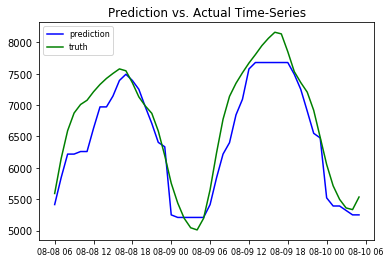

In [21]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib inline
pred, = plt.plot(df_all[time_column_name], df_all['predicted'], color='b')
actual, = plt.plot(df_all[time_column_name], df_all[target_column_name], color='g')
plt.xticks(fontsize=8)
plt.legend((pred, actual), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.title('Prediction vs. Actual Time-Series')

plt.show()

The distribution looks a little heavy tailed: we underestimate the excursions of the extremes. A normal-quantile transform of the target might help, but let's first try using some past data with the lags and rolling window transforms.


### Using lags and rolling window features

We did not use lags in the previous model specification. In effect, the prediction was the result of a simple regression on date, grain and any additional features. This is often a very good prediction as common time series patterns like seasonality and trends can be captured in this manner. Such simple regression is horizon-less: it doesn't matter how far into the future we are predicting, because we are not using past data. In the previous example, the horizon was only used to split the data for cross-validation.

Now that we configured target lags, that is the previous values of the target variables, and the prediction is no longer horizon-less. We therefore must still specify the `max_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

In [22]:
time_series_settings_with_lags = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    'target_lags': 12,
    'target_rolling_window_size': 4
}

automl_config_lags = AutoMLConfig(task='forecasting',
                                  debug_log='automl_nyc_energy_errors.log',
                                  primary_metric='normalized_root_mean_squared_error',
                                  blacklist_models=['ElasticNet','ExtremeRandomTrees','GradientBoosting'],
                                  iterations=10,
                                  iteration_timeout_minutes=10,
                                  X=X_train,
                                  y=y_train,
                                  n_cross_validations=3,
                                  path=project_folder,
                                  verbosity=logging.INFO,
                                  **time_series_settings_with_lags)

We now start a new local run, this time with lag and rolling window featurization. AutoML applies featurizations in the setup stage, prior to iterating over ML models. The full training set is featurized first, followed by featurization of each of the CV splits. Lag and rolling window features introduce additional complexity, so the run will take longer than in the previous example that lacked these featurizations.

In [23]:
local_run_lags = experiment.submit(automl_config_lags, show_output=True)

Running on local machine
Parent Run ID: AutoML_23d564d0-c483-4658-a3e9-a7e8f9cd2e0c
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:04:18       0.0762  

In [24]:
best_run_lags, fitted_model_lags = local_run_lags.get_output()
y_fcst_lags, X_trans_lags = fitted_model_lags.forecast(X_test, y_query)
df_lags = align_outputs(y_fcst_lags, X_trans_lags, X_test, y_test)
df_lags.head()

,timeStamp,_automl_dummy_grain_col,origin,predicted,precip,temp,demand
0,2017-08-08 06:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,5264.52,0.00,66.17,5590.99
1,2017-08-08 07:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6016.81,0.00,66.29,6147.03
2,2017-08-08 08:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6122.10,0.00,66.72,6592.43
3,2017-08-08 09:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6711.43,0.00,67.37,6874.53
4,2017-08-08 10:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6711.43,0.00,68.30,7010.54


In [25]:
X_trans_lags

,,,horizon_origin,precip,precip_WASNULL,temp,temp_WASNULL,_automl_target_col_lag12H,_automl_target_col_min_window4H,_automl_target_col_max_window4H,_automl_target_col_mean_window4H,year,...,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timeStamp,_automl_dummy_grain_col,origin,,,,,,,,,,,,,,,,,,,,,
2017-08-08 06:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,1,0.00,0.00,66.17,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,6,0,6,1,39,32,5264.52
2017-08-08 07:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,2,0.00,0.00,66.29,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,7,0,7,1,39,32,6016.81
2017-08-08 08:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,3,0.00,0.00,66.72,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,8,0,8,1,39,32,6122.10
2017-08-08 09:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,4,0.00,0.00,67.37,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,9,0,9,1,39,32,6711.43
2017-08-08 10:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,5,0.00,0.00,68.30,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,10,0,10,1,39,32,6711.43
2017-08-08 11:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6,0.00,0.00,68.89,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,11,0,11,1,39,32,6711.43
2017-08-08 12:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,7,0.00,0.00,70.60,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,12,1,12,1,39,32,6711.43
2017-08-08 13:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,8,0.00,0.00,72.83,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,13,1,1,1,39,32,6711.43
2017-08-08 14:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,9,0.00,0.00,73.33,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,14,1,2,1,39,32,7054.03


Forecasting model with lags
[Test Data] 
Root Mean squared error: 316.13
mean_absolute_error score: 263.91
MAPE: 4.02


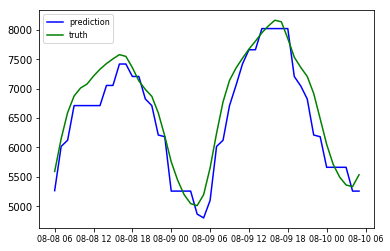

In [26]:
print("Forecasting model with lags")
rmse = np.sqrt(mean_squared_error(df_lags[target_column_name], df_lags['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_lags[target_column_name], df_lags['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_lags[target_column_name], df_lags['predicted']))

# Plot outputs
%matplotlib inline
pred, = plt.plot(df_lags[time_column_name], df_lags['predicted'], color='b')
actual, = plt.plot(df_lags[time_column_name], df_lags[target_column_name], color='g')
plt.xticks(fontsize=8)
plt.legend((pred, actual), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

### What features matter for the forecast?

In [27]:
from azureml.train.automl.automlexplainer import explain_model

# feature names are everything in the transformed data except the target
features = X_trans_lags.columns[:-1]
expl = explain_model(fitted_model_lags, X_train.copy(), X_test.copy(), features=features, best_run=best_run_lags, y_train=y_train)
# unpack the tuple
shap_values, expected_values, feat_overall_imp, feat_names, per_class_summary, per_class_imp = expl
best_run_lags

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_23d564d0-c483-4658-a3e9-a7e8f9cd2e0c_9,,Completed,Link to Azure Portal,Link to Documentation


Please go to the Azure Portal's best run to see the top features chart.

The informative features make all sorts of intuitive sense. Temperature is a strong driver of heating and cooling demand in NYC. Apart from that, the daily life cycle, expressed by `hour`, and the weekly cycle, expressed by `wday` drives people's energy use habits.

> Fin